# Initial Study: Examining Speculative Decoding Outputs

In [1]:
prompt = "A monolithic operating system differs"
num_iterations = 10
target_checkpoint = "facebook/opt-6.7b"

draft_models = [
	"facebook/opt-125m",
	"facebook/opt-350m",
	"facebook/opt-1.3b",
	"facebook/opt-2.7b",
    "facebook/opt-6.7b",
]

model_size = {
    "facebook/opt-125m": 125 * 1,
	"facebook/opt-350m": 350 * 1,
	"facebook/opt-1.3b": 1.3 * 1000,
	"facebook/opt-2.7b": 2.7 * 1000,
    "facebook/opt-6.7b": 6.7 * 1000
}

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# To pre-cache all the OPT models easily (in parallel),
# use `../precache_opt_models.py HF_CACHE_LOCATION`
HF_CACHE_LOCATION = "/data/shk148/models/opt/cache"

# For processing on GPU, we use PyTorch
# TensorFlow is also available, but Transformers' integration with PyTorch is more robust
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the target model into the GPU
target_model = AutoModelForCausalLM.from_pretrained(target_checkpoint, cache_dir=HF_CACHE_LOCATION).to(torch_device)
tokenizer = AutoTokenizer.from_pretrained(target_checkpoint, cache_dir=HF_CACHE_LOCATION)

# Prepare the inputs
inputs = tokenizer(prompt, return_tensors="pt").input_ids.to(torch_device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
import gc
import time

def evaluate_llm(assistant_checkpoint):
    # Perform inference and measure latency
    total_time = 0.0

    if assistant_checkpoint != target_checkpoint:
        assistant_model = AutoModelForCausalLM.from_pretrained(assistant_checkpoint, cache_dir="/data/shk148/models/opt/cache").to(torch_device)
        for _ in range(num_iterations):
            with torch.no_grad():
                start_time = time.time()
                output = target_model.generate(inputs, assistant_model=assistant_model, max_new_tokens=100)
                total_time += time.time() - start_time
                del output
            torch.cuda.empty_cache()
        del assistant_model
    
    else:
        for _ in range(num_iterations):
            with torch.no_grad():
                start_time = time.time()
                output = target_model.generate(inputs, max_new_tokens=100)
                total_time += time.time() - start_time
                del output
            torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    return (total_time / num_iterations)

In [4]:
results = dict()
for model in draft_models:
    results[model_size[model]] = evaluate_llm(model)    

Calling `_assisted_decoding` directly is deprecated and will be removed in v4.41. Use `generate` or a custom generation loop instead.


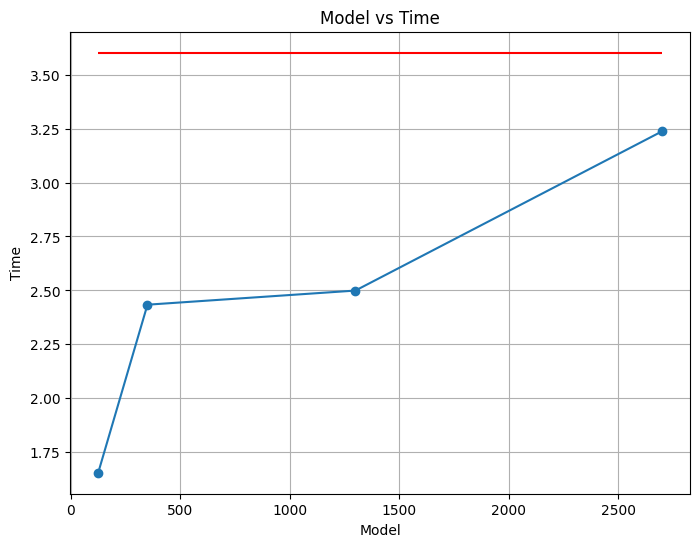

In [5]:
import pandas as pd
df = pd.DataFrame(list(results.items()), columns=['Model', 'Time'])

import matplotlib.pyplot as plt
no_spec = df.iloc[-1]
df = df.drop(df.index[-1])

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(df['Model'], df['Time'], marker='o', linestyle='-')
plt.hlines(no_spec['Time'],xmin=df.head(1)['Model'], xmax=df.tail(1)['Model'],color='red')
plt.title('Model vs Time')
plt.xlabel('Model')
plt.ylabel('Time')
plt.grid(True)
plt.show()
